# Capstone: supervised learning

## Online News Popularity Project


You're ready to put into practice everything you've learned so far.

First: Go out and find a dataset of interest. It could be from one of our recommended resources, some other aggregation, or scraped yourself. Just make sure it has lots of variables in it, including an outcome of interest to you.

Second: Explore the data. Get to know the data. Spend a lot of time going over its quirks and peccadilloes. You should understand how it was gathered, what's in it, and what the variables look like.

Third: Model your outcome of interest. You should try several different approaches and really work to tune a variety of models before using the model evaluation techniques to choose what you consider to be the best performer. Make sure to think about explanatory versus predictive power and experiment with both.

So, here is the deliverable: Prepare a slide deck and 15 minute presentation that guides viewers through your model. Be sure to cover a few specific things:

A specified research question your model addresses
How you chose your model specification and what alternatives you compared it to
The practical uses of your model for an audience of interest
Any weak points or shortcomings of your model
This presentation is not a drill. You'll be presenting this slide deck live to a group as the culmination of all your work so far on supervised learning. As a secondary matter, your slides and / or the Jupyter notebook you use or adapt them into should be worthy of inclusion as examples of your work product when applying to jobs

The dataset is      and it was downloaded from this [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/online+news+popularity)

In [263]:
import pandas as pd
import numpy as np
import seaborn as sns


import matplotlib.pyplot as plt

import time

from sklearn import metrics

%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split

from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report,confusion_matrix

from sklearn import tree
from IPython.display import Image


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix



## Loading Data

In [2]:
#Loading data

onlinenews = pd.read_csv('OnlineNewsPopularity.csv')


for col in onlinenews.columns:
    onlinenews.rename(columns={col:col.replace(" ", "")},inplace=True)


onlinenews.head()

url  timedelta  \
0  http://mashable.com/2013/01/07/amazon-instant-...      731.0   
1  http://mashable.com/2013/01/07/ap-samsung-spon...      731.0   
2  http://mashable.com/2013/01/07/apple-40-billio...      731.0   
3  http://mashable.com/2013/01/07/astronaut-notre...      731.0   
4   http://mashable.com/2013/01/07/att-u-verse-apps/      731.0   

   n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0            12.0             219.0         0.663594               1.0   
1             9.0             255.0         0.604743               1.0   
2             9.0             211.0         0.575130               1.0   
3             9.0             531.0         0.503788               1.0   
4            13.0            1072.0         0.415646               1.0   

   n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  num_imgs   ...    \
0                  0.815385        4.0             2.0       1.0   ...     
1                  0.791946        3.0             1.0       1.0   ...     
2                  0.663866        3.0             1.0       1.0   ...     
3                  0.665635        9.0             0.0       1.0   ...     
4                  0.540890       19.0            19.0      20.0   ...     

   min_positive_polarity  max_positive_polarity  avg_negative_polarity  \
0               0.100000                    0.7              -0.350000   
1               0.033333                    0.7              -0.118750   
2               0.100000                    1.0              -0.466667   
3               0.136364                    0.8              -0.369697   
4               0.033333                    1.0              -0.220192   

   min_negative_polarity  max_negative_polarity  title_subjectivity  \
0                 -0.600              -0.200000            0.500000   
1                 -0.125              -0.100000            0.000000   
2                 -0.800              -0.133333            0.000000   
3                 -0.600              -0.166667            0.000000   
4                 -0.500              -0.050000            0.454545   

   title_sentiment_polarity  abs_title_subjectivity  \
0                 -0.187500                0.000000   
1                  0.000000                0.500000   
2                  0.000000                0.500000   
3                  0.000000                0.500000   
4                  0.136364                0.045455   

   abs_title_sentiment_polarity  shares  
0                      0.187500     593  
1                      0.000000     711  
2                      0.000000    1500  
3                      0.000000    1200  
4                      0.136364     505  

[5 rows x 61 columns]

In [3]:
onlinenews.info()  #There is just one object type, categorical variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
url                              39644 non-null object
timedelta                        39644 non-null float64
n_tokens_title                   39644 non-null float64
n_tokens_content                 39644 non-null float64
n_unique_tokens                  39644 non-null float64
n_non_stop_words                 39644 non-null float64
n_non_stop_unique_tokens         39644 non-null float64
num_hrefs                        39644 non-null float64
num_self_hrefs                   39644 non-null float64
num_imgs                         39644 non-null float64
num_videos                       39644 non-null float64
average_token_length             39644 non-null float64
num_keywords                     39644 non-null float64
data_channel_is_lifestyle        39644 non-null float64
data_channel_is_entertainment    39644 non-null float64
data_channel_is_bus              39644 non-null floa

## Data Cleaning

### Variables Type

In [4]:
#Identifying categorical and continuos variables

categorical = onlinenews.select_dtypes(include=['object'])

for i in categorical:
    column = categorical[i]
    print('Variable: {} with {} unique values '.format(i,column.nunique()))

#Remove the only categorical variable, it is not needed in this analysis
onlinenews = onlinenews.drop('url', axis =1)

Variable: url with 39644 unique values 


### Missing Values

All null values are in yellow


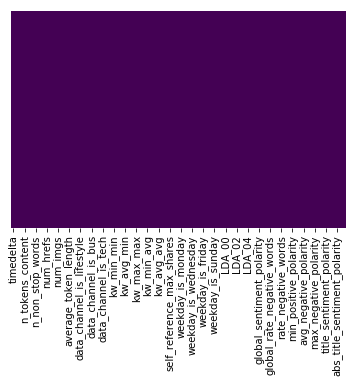

In [5]:
#Looking for null values

print('All null values are in yellow')
sns.heatmap(onlinenews.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Dealing with Outliers

In [6]:
#Function to create a list of variables with outliers

def outliersinColumns(df):

    '''
    function: outliersinColumns verifies if there is a True value into de dataset to indicate there is an
              outlier in a specific column
    arguments: A dataframe with boolean values
    return: A list of columns with outliers
    '''
    
    columns_outliers = []
    for column in df.columns:

        if onlinenews[column].nunique() > 2:  #Apply for variables with 3 or more unique values

            for value in df[column]:
                if value:
                    columns_outliers.append(column)
                    break

    return columns_outliers

In [7]:
#Using a statistical method to detect outliers: interquartile range (IQR)

Q1 = onlinenews.quantile(0.25)
Q3 = onlinenews.quantile(0.75)
IQR = Q3 - Q1


#Creating notinvalidarea dataframe with boolean values:
#False means these values are into the valid area 
#True indicates presence of an outlier

notinvalidarea = (onlinenews < (Q1 - 1.5 * IQR)) | (onlinenews > (Q3 + 1.5 * IQR))


#Calling function outliersinColumns
columns_w_outliers = outliersinColumns(notinvalidarea)


#Printing Results
print('Columns with outliers: {}'.format(len(columns_w_outliers)))
print('\n')
print(columns_w_outliers)

Columns with outliers: 39


['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity', 'avg_negative_polarity', 'max_negative_polarity', 'title_sentiment_polarity', 'abs_title_sentiment_polarity', 'shares']


####  [Click here](Online%20News%20Popularity%20-%20Dealing%20with%20outliers.ipynb) to see the details about how treating outliers in this dataset

In [8]:
#Creating a dictionary with variables and its technique to be applied
#
#    1 - log transformation,
#    2 - one-way winsorization to the highest end,
#    3 - one-way winsorization to the lowest end,
#    4 - two-way winsorization

# 'LDA_00':1, 'LDA_01':1, 'LDA_02':1, 'LDA_03':1, 

transformation = {'n_tokens_title':4, 'n_tokens_content':2, 'n_unique_tokens':4, 'n_non_stop_words':4, 'n_non_stop_unique_tokens':4, 
 'num_hrefs':2, 'num_self_hrefs':2, 'num_videos':2, 'average_token_length':4, 
 'num_keywords':3, 'kw_max_min':2, 'kw_avg_min':2, 
 'kw_avg_max':2, 'kw_max_avg':2, 'kw_avg_avg':4, 'global_subjectivity':4, 
 'global_sentiment_polarity':4, 'global_rate_positive_words':2, 'global_rate_negative_words':2, 
 'rate_positive_words':3, 'rate_negative_words':2, 'avg_positive_polarity':4, 'min_positive_polarity':2, 
 'avg_negative_polarity':3, 'max_negative_polarity':3, 'abs_title_sentiment_polarity':2}

In [9]:
from scipy.stats.mstats import winsorize

#Dropping outliers from dataset, this technique is applied because the outier is just one row
#onlinenews = onlinenews.drop(index=onlinenews[onlinenews['n_unique_tokens']>200].index[0])

#Transforming outliers
#    1 - log transformation,
#    2 - one-way winsorization to the highest end,
#    3 - one-way winsorization to the lowest end,
#    4 - two-way winsorization

for k in transformation:
    if transformation[k] == 1:
        onlinenews[k] = np.log(onlinenews[k])
        
    elif transformation[k] == 2:
        onlinenews[k] = winsorize(onlinenews[k],(0,0.10))

    elif transformation[k] == 3:
        onlinenews[k] = winsorize(onlinenews[k],(0.10,0))
        
    elif transformation[k] == 4:
        onlinenews[k] = winsorize(onlinenews[k],(0.10,0.10))

All null values are in yellow


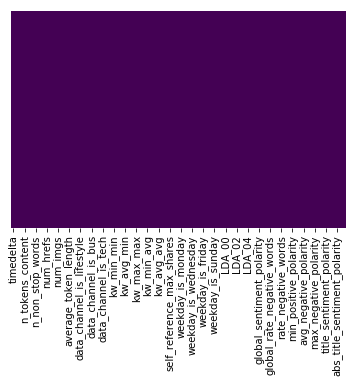

In [10]:

print('All null values are in yellow')
sns.heatmap(onlinenews.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Data Exploration

### Correlation

Text(0.5,1,'Correlation Matrix (Online News)')

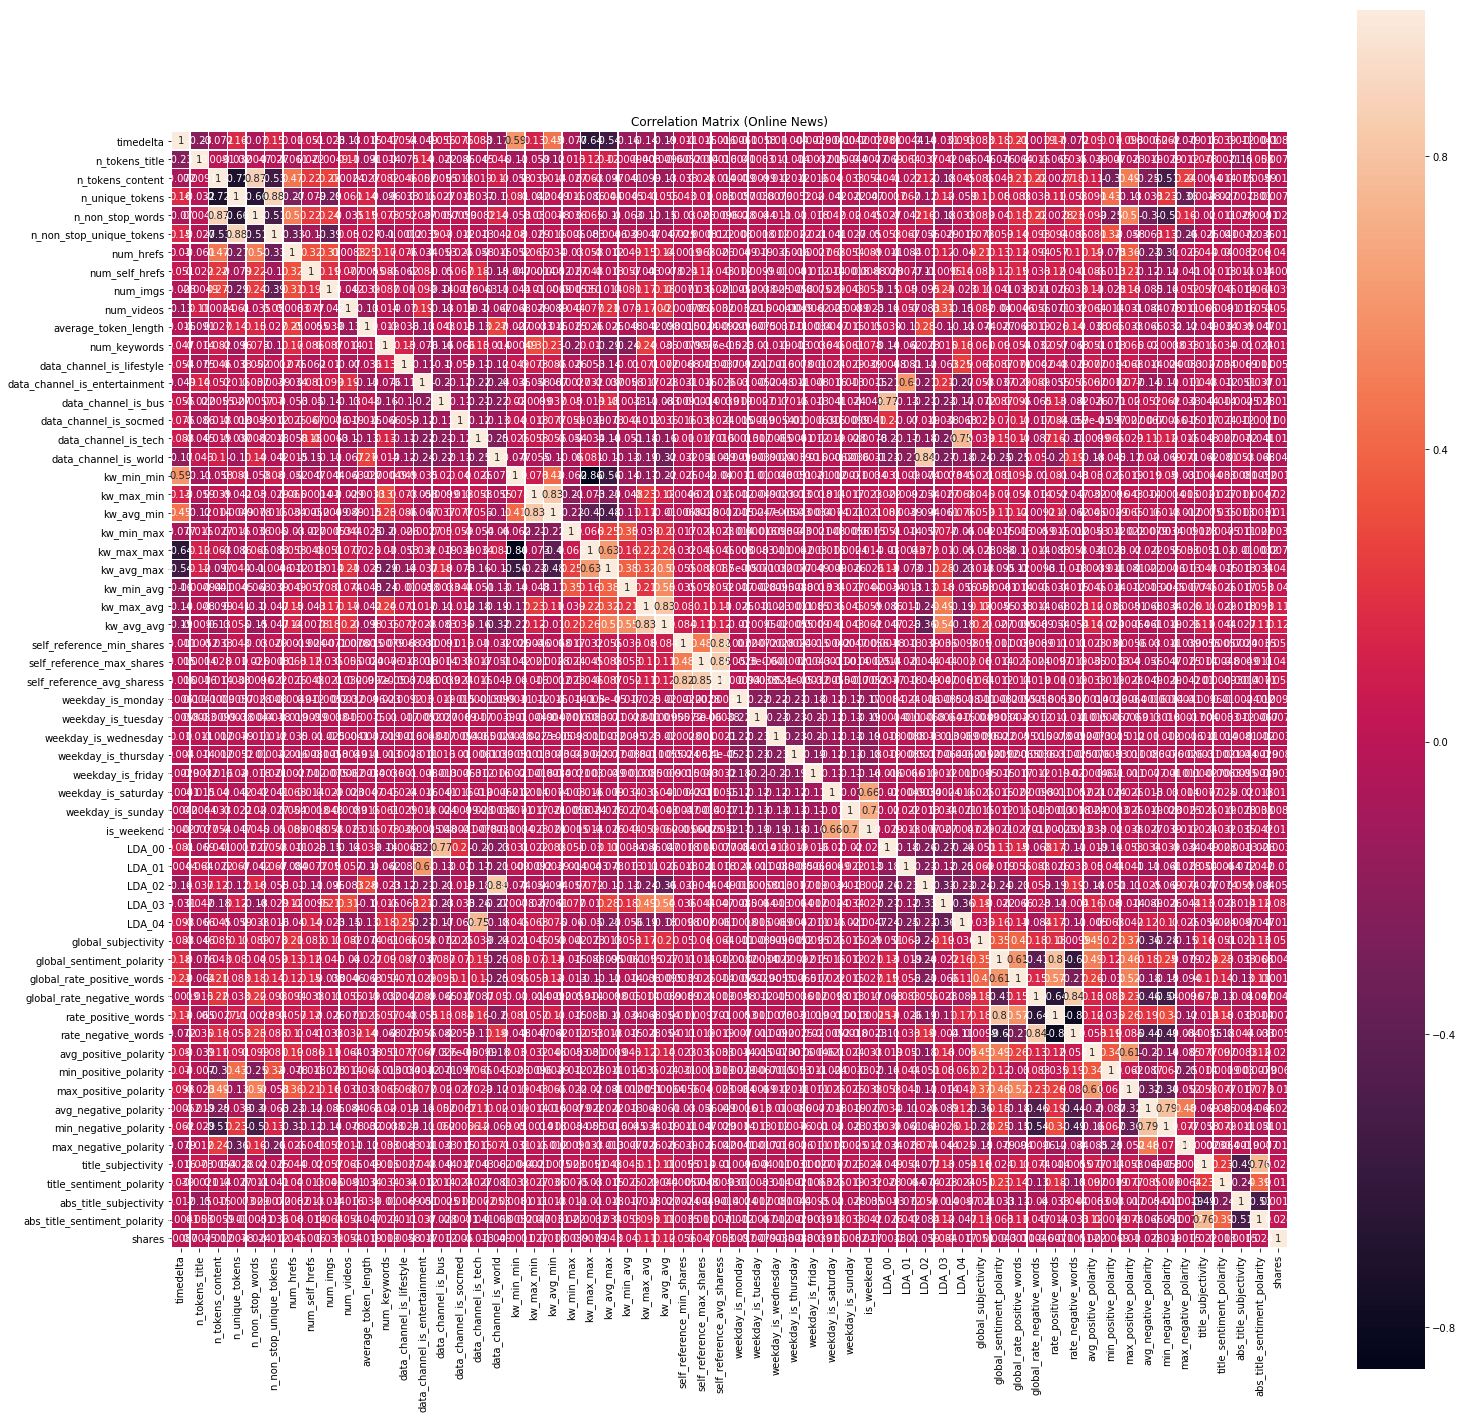

In [12]:
#Check correlation

correlation = onlinenews.corr()

plt.figure(figsize=(25,25))
sns.heatmap(correlation, square=True, annot=True, linewidths=.5)
plt.title("Correlation Matrix (Online News)")


In [13]:
correlation.head(5)

timedelta  n_tokens_title  n_tokens_content  \
timedelta          1.000000       -0.233211         -0.071554   
n_tokens_title    -0.233211        1.000000          0.009117   
n_tokens_content  -0.071554        0.009117          1.000000   
n_unique_tokens    0.164191       -0.032076         -0.718489   
n_non_stop_words  -0.070445        0.004716          0.870803   

                  n_unique_tokens  n_non_stop_words  n_non_stop_unique_tokens  \
timedelta                0.164191         -0.070445                  0.147116   
n_tokens_title          -0.032076          0.004716                 -0.027421   
n_tokens_content        -0.718489          0.870803                 -0.532404   
n_unique_tokens          1.000000         -0.655684                  0.879803   
n_non_stop_words        -0.655684          1.000000                 -0.506361   

                  num_hrefs  num_self_hrefs  num_imgs  num_videos    ...     \
timedelta          0.010343        0.051220 -0.027636   -0.126569    ...      
n_tokens_title    -0.060520        0.022053 -0.004944    0.109599    ...      
n_tokens_content   0.468414        0.224323  0.273554    0.002444    ...      
n_unique_tokens   -0.268414       -0.079379 -0.287299    0.060732    ...      
n_non_stop_words   0.498033        0.224740  0.241489   -0.035309    ...      

                  min_positive_polarity  max_positive_polarity  \
timedelta                      0.069531               0.098288   
n_tokens_title                -0.007003              -0.023333   
n_tokens_content              -0.297832               0.486256   
n_unique_tokens                0.430082              -0.126576   
n_non_stop_words              -0.251031               0.500474   

                  avg_negative_polarity  min_negative_polarity  \
timedelta                      0.000625               0.062175   
n_tokens_title                -0.018862              -0.028688   
n_tokens_content              -0.246734              -0.508320   
n_unique_tokens               -0.037770               0.228044   
n_non_stop_words              -0.299792              -0.501740   

                  max_negative_polarity  title_subjectivity  \
timedelta                     -0.079139           -0.015919   
n_tokens_title                 0.012432            0.077621   
n_tokens_content               0.244957           -0.005403   
n_unique_tokens               -0.355336            0.002823   
n_non_stop_words               0.158858           -0.019992   

                  title_sentiment_polarity  abs_title_subjectivity  \
timedelta                         0.038711                0.011551   
n_tokens_title                   -0.002063               -0.147129   
n_tokens_content                  0.014230                0.014622   
n_unique_tokens                  -0.027459               -0.007273   
n_non_stop_words                  0.011297                0.028537   

                  abs_title_sentiment_polarity    shares  
timedelta                            -0.004082  0.008662  
n_tokens_title                        0.058465  0.007501  
n_tokens_content                      0.005934 -0.012172  
n_unique_tokens                      -0.010089  0.007808  
n_non_stop_words                     -0.005069 -0.023658  

[5 rows x 60 columns]

In [14]:
#Check the correlation with target variable

correlation['shares'].sort_values(ascending=True)

LDA_02                          -0.059163
data_channel_is_world           -0.049497
avg_negative_polarity           -0.027922
n_non_stop_words                -0.023658
average_token_length            -0.019301
min_negative_polarity           -0.019297
data_channel_is_entertainment   -0.017006
LDA_04                          -0.016622
max_negative_polarity           -0.015133
data_channel_is_tech            -0.013253
data_channel_is_bus             -0.012376
n_tokens_content                -0.012172
n_non_stop_unique_tokens        -0.012068
LDA_01                          -0.010183
weekday_is_thursday             -0.008833
weekday_is_tuesday              -0.007941
rate_positive_words             -0.007097
min_positive_polarity           -0.006938
num_self_hrefs                  -0.005956
rate_negative_words             -0.005091
weekday_is_friday               -0.003884
weekday_is_wednesday            -0.003801
LDA_00                          -0.003793
kw_min_min                      -0

**NOTE: I've got a classification problem, not a regression problem. Low correlation means there's no linear relationship; it doesn't mean there's no information in the feature that predicts the target**

### Feature Enginnering - Dimensionality Reduction

Statistic details of target (shares)
count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64


Statistic details of tha last 4ht quantile of the target (shares)
count      9630.000000
mean       9942.969470
std       22335.194959
min        2900.000000
25%        3700.000000
50%        5300.000000
75%        9300.000000
max      843300.000000
Name: shares, dtype: float64


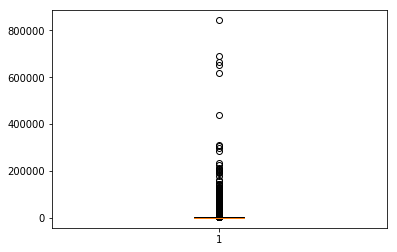

In [15]:
#As mentoned above, this is not a regression problem, so we need binning the target
#Groups were defined by its quantiles

print('Statistic details of target (shares)')
#print('\n')
print(onlinenews['shares'].describe())
print('\n')
print('Statistic details of tha last 4ht quantile of the target (shares)')
print(onlinenews[onlinenews['shares']>2800]['shares'].describe())

plt.boxplot(onlinenews['shares'])
plt.show()

In [16]:
#5 groups: 'Very Low','Low','Medium','High','Super High'

onlinenews['labelbin_shares'] = pd.cut(onlinenews['shares'], bins=[0,946,9300,843300], labels=['Low','Medium','High'])
onlinenews['bin_shares'] = pd.cut(onlinenews['shares'], bins=[0,946,9300,843300], labels=[1,2,3])


### Feature Selection 

#### Technique: Filter Method

In [281]:
#Select the most correlated variables

correlationshares=correlation['shares'].sort_values(ascending=True)


selectedFeatures_1 = []
for i,c in zip(correlationshares.index,correlationshares):
    if (c > 0.022) or (c <= -0.019):
        selectedFeatures_1.append(i)

selectedFeatures_1.remove('shares')

print(selectedFeatures_1)
print(len(selectedFeatures_1))

['LDA_02', 'data_channel_is_world', 'avg_negative_polarity', 'n_non_stop_words', 'average_token_length', 'min_negative_polarity', 'avg_positive_polarity', 'abs_title_sentiment_polarity', 'kw_max_min', 'num_imgs', 'kw_min_avg', 'kw_avg_max', 'num_hrefs', 'self_reference_max_shares', 'global_subjectivity', 'num_videos', 'self_reference_min_shares', 'self_reference_avg_sharess', 'LDA_03', 'kw_max_avg', 'kw_avg_avg']
21


#### Technique: Univariate feature selection using SelectKBest

In [288]:
#Univariate Selection

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


X = onlinenews.drop(columns=['labelbin_shares','shares','bin_shares'])
y = onlinenews['bin_shares']    #target column i.e price range


# Create an SelectKBest object to select features with two best ANOVA F-Values
fvalue_selector = SelectKBest(f_classif, k=21)

# Apply the SelectKBest object to the features and target
X_kbest = fvalue_selector.fit_transform(X, y)

print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_kbest.shape[1])


mask = fvalue_selector.get_support() #list of booleans
selectedFeatures_2 = [] # The list of your K best features

for bool, feature in zip(mask, X.columns.values):
    if bool:
        selectedFeatures_2.append(feature)

print(selectedFeatures_2)

Original number of features: 61
Reduced number of features: 21
['num_hrefs', 'num_imgs', 'data_channel_is_entertainment', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_max_min', 'kw_avg_min', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'pca_1']


#### Technique:  Tree based feature selection

In [355]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

forest = ExtraTreesClassifier(n_estimators=50)
forest = forest.fit(X, y) 

model = SelectFromModel(forest, prefit=True)
X_new = model.transform(X)

print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_new.shape[1])


importances = forest.feature_importances_ #array with importances of each feature

feature_importances = pd.DataFrame(importances,
                                   index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

m = feature_importances[feature_importances['importance']>feature_importances['importance'].mean()]['importance']

selectedFeatures_3 = []
for i in m.index:
        selectedFeatures_3.append(i)
        
selectedFeatures_3

Original number of features: 43
Reduced number of features: 18


['kw_avg_avg',
 'LDA_04',
 'timedelta',
 'kw_max_avg',
 'LDA_02',
 'LDA_01',
 'LDA_00',
 'kw_avg_min',
 'LDA_03',
 'kw_max_min',
 'kw_avg_max',
 'num_hrefs',
 'n_tokens_title',
 'kw_min_avg',
 'pca_2',
 'average_token_length',
 'global_subjectivity',
 'global_rate_positive_words']

### Random Forest - Group 1 of Selected Features 

In [398]:
# Random Forest - selected features group 1

X = onlinenews[selectedFeatures_1]
Y = onlinenews['bin_shares']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.35, random_state = 101)

#Setting start time to calculate runtime
start_time = time.time()

#Creating an instance of the RandomForestClassifier class
rfc = ensemble.RandomForestClassifier(n_estimators=1000,  min_samples_split=8, criterion='gini')

#Fitting the model
rfc.fit(X_train,y_train)

#Making predictions
predictionsrfc = rfc.predict(X_test)

print("--- Runtime: %s seconds ---" % (time.time() - start_time))

--- Runtime: 52.56418204307556 seconds ---


In [399]:
score = round(rfc.score(X_train, y_train),4)
print('Score: {}'.format(score))

Score: 0.9552


In [400]:
accu_score = round(metrics.accuracy_score(y_test, predictionsrfc),4)
print('Accuracy Score:{}'.format(accu_score))


Accuracy Score:0.7007


In [401]:
print(classification_report(y_test,predictionsrfc))

             precision    recall  f1-score   support

          1       0.57      0.11      0.19      3437
          2       0.71      0.97      0.82      9612
          3       0.50      0.00      0.00       827

avg / total       0.66      0.70      0.61     13876



In [402]:
print(metrics.confusion_matrix(y_test, predictionsrfc))

[[ 386 3051    0]
 [ 275 9336    1]
 [  11  815    1]]


In [403]:
#Create a DataFrame object for saving results

results = pd.DataFrame(columns = ['Model' , 'Model_score', 'Accuracy_score' ,'features_group'])

#Adding results from Random forest model with features group 1

results = results.append({'Model': 'Random Forest', 'Model_score': score, 
                          'Accuracy_score': accu_score ,'features_group':1},
                        ignore_index=True)


#### Using GridSearch for better parameters

In [ ]:
#Using GridSearch to find best parameters


from sklearn.grid_search import GridSearchCV

param_grid = {'n_estimators':[100,1000,3000],'min_samples_split':[2,8],'criterion':['gini','entropy']}

grid = GridSearchCV(ensemble.RandomForestClassifier(),param_grid, verbose=2)

grid.fit(X_train,y_train)

best_parameters = grid.best_params_

print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print('\n')
print(classification_report(y_test,grid_predictions))


print(grid.best_estimator_)
print(best_parameters)



/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] criterion=gini, min_samples_split=2, n_estimators=100 ...........
[CV] .. criterion=gini, min_samples_split=2, n_estimators=100 -   3.5s
[CV] criterion=gini, min_samples_split=2, n_estimators=100 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] .. criterion=gini, min_samples_split=2, n_estimators=100 -   3.6s
[CV] criterion=gini, min_samples_split=2, n_estimators=100 ...........
[CV] .. criterion=gini, min_samples_split=2, n_estimators=100 -   3.5s
[CV] criterion=gini, min_samples_split=2, n_estimators=1000 ..........
[CV] . criterion=gini, min_samples_split=2, n_estimators=1000 -  35.2s
[CV] criterion=gini, min_samples_split=2, n_estimators=1000 ..........
[CV] . criterion=gini, min_samples_split=2, n_estimators=1000 -  35.2s
[CV] criterion=gini, min_samples_split=2, n_estimators=1000 ..........
[CV] . criterion=gini, min_samples_split=2, n_estimators=1000 -  35.0s
[CV] criterion=gini, min_samples_split=2, n_estimators=3000 ..........
[CV] . criterion=gini, min_samples_split=2, n_estimators=3000 - 1.8min
[CV] criterion=gini, min_samples_split=2, n_estimators=3000 ..........
[CV] . criterion=gini, min_samples_split=2, n_estimators=3000 - 1.8min
[CV] criterion=gini, min_samples_split=2, n_estimators=3000 ..........


### Random Forest - Group 2 of Selected Features

In [ ]:
# Random Forest - selected features group 1

X = onlinenews[selectedFeatures_2]
Y = onlinenews['bin_shares']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.35, random_state = 101)

#Setting start time to calculate runtime
start_time = time.time()

#Creating an instance of the RandomForestClassifier class
rfc = ensemble.RandomForestClassifier(n_estimators=1000,  min_samples_split=8, criterion='gini')

#Fitting the model
rfc.fit(X_train,y_train)

#Making predictions
predictionsrfc = rfc.predict(X_test)

print("--- Runtime: %s seconds ---" % (time.time() - start_time))

In [ ]:
score = round(rfc.score(X_train, y_train),4)
print('Score: {}'.format(score))

In [ ]:
accu_score = round(metrics.accuracy_score(y_test, predictionsrfc),4)
print('Accuracy Score:{}'.format(accu_score))



In [ ]:
print(classification_report(y_test,predictionsrfc))

In [ ]:
print(metrics.confusion_matrix(y_test, predictionsrfc))

In [ ]:
#Adding results from Random forest model with features group 1

results = results.append({'Model': 'Random Forest', 'Model_score': score, 
                          'Accuracy_score': accu_score ,'features_group':2},
                        ignore_index=True)



#### Using GridSearch for better parameters

In [ ]:
#Using GridSearch to find best parameters


from sklearn.grid_search import GridSearchCV

param_grid = {'n_estimators':[100,1000,3000],'min_samples_split':[2,8],'criterion':['gini','entropy']}

grid = GridSearchCV(ensemble.RandomForestClassifier(),param_grid, verbose=2)

grid.fit(X_train,y_train)

best_parameters = grid.best_params_

print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print('\n')
print(classification_report(y_test,grid_predictions))


print(grid.best_estimator_)
print(best_parameters)



### Random Forest - Group 3 of Selected Features

In [ ]:
# Random Forest - selected features group 1

X = onlinenews[selectedFeatures_3]
Y = onlinenews['bin_shares']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.35, random_state = 101)

#Setting start time to calculate runtime
start_time = time.time()

#Creating an instance of the RandomForestClassifier class
rfc = ensemble.RandomForestClassifier(n_estimators=1000,  min_samples_split=8, criterion='gini')

#Fitting the model
rfc.fit(X_train,y_train)

#Making predictions
predictionsrfc = rfc.predict(X_test)

print("--- Runtime: %s seconds ---" % (time.time() - start_time))

In [ ]:
score = round(rfc.score(X_train, y_train),4)
print('Score: {}'.format(score))

In [ ]:
accu_score = round(metrics.accuracy_score(y_test, predictionsrfc),4)
print('Accuracy Score:{}'.format(accu_score))

In [ ]:
print(classification_report(y_test,predictionsrfc))

In [ ]:
print(metrics.confusion_matrix(y_test, predictionsrfc))

In [ ]:
#Adding results from Random forest model with features group 1

results = results.append({'Model': 'Random Forest', 'Model_score': score, 
                          'Accuracy_score': accu_score ,'features_group':3},
                        ignore_index=True)



In [ ]:
results

#### Using GridSearch for better parameters

In [ ]:
#Using GridSearch to find best parameters


from sklearn.grid_search import GridSearchCV

param_grid = {'n_estimators':[100,1000,3000],'min_samples_split':[2,8],'criterion':['gini','entropy']}

grid = GridSearchCV(ensemble.RandomForestClassifier(),param_grid, verbose=2)

grid.fit(X_train,y_train)

best_parameters = grid.best_params_

print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print('\n')
print(classification_report(y_test,grid_predictions))


print(grid.best_estimator_)
print(best_parameters)



### Support Vector Classification - Group 1 of Selected Features

In [ ]:
from sklearn.svm import SVC


X = onlinenews[selectedFeatures_1]
Y = onlinenews['bin_shares']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.35, random_state = 101)


svc = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)



In [ ]:
svc.fit(X_train,y_train)

predictions = svc.predict(X_test)

score = svc.score(X_train, y_train)

In [ ]:
target_names = ['Low','Medium','High']

print(classification_report(y_test, predictions, target_names=target_names))

In [ ]:
accu_score = round(metrics.accuracy_score(y_test, predictions),4)
print(accu_score)

In [ ]:
print(metrics.confusion_matrix(y_test, predictions))

In [ ]:
results = results.append({'Model': 'SVC', 'Model_score': score, 
                          'Accuracy_score': accu_score ,'features_group':1},
                        ignore_index=True)

#### Tunning SVC with GridSearch

In [ ]:
#Using GridSearch to find best parameters


from sklearn.grid_search import GridSearchCV

param_grid = {'C' : [1,0.1,0.001],
              'gamma': [0.001,0.01,1]}

grid = GridSearchCV(SVC(),param_grid,verbose=2)
grid.fit(X_train,y_train)
best_parameters = grid.best_params_
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print('\n')
print(classification_report(y_test,grid_predictions))



### Support Vector Classification - Group 2 of Selected Features

In [ ]:
from sklearn.svm import SVC


X = onlinenews[selectedFeatures_2]
Y = onlinenews['bin_shares']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.35, random_state = 101)


svc = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)



In [ ]:
svc.fit(X_train,y_train)

predictions = svc.predict(X_test)

score = svc.score(X_train, y_train)

In [ ]:
target_names = ['Low','Medium','High']

print(classification_report(y_test, predictions, target_names=target_names))

In [ ]:
accu_score = round(metrics.accuracy_score(y_test, predictions),4)
print(accu_score)

In [ ]:
print(metrics.confusion_matrix(y_test, predictions))

In [ ]:
results = results.append({'Model': 'SVC', 'Model_score': score, 
                          'Accuracy_score': accu_score ,'features_group':2},
                        ignore_index=True)

#### Tunning SVC with GridSearch

In [ ]:
#Using GridSearch to find best parameters


from sklearn.grid_search import GridSearchCV

param_grid = {'C' : [1,0.1,0.001],
              'gamma': [0.001,0.01,1]}

grid = GridSearchCV(SVC(),param_grid,verbose=2)
grid.fit(X_train,y_train)
best_parameters = grid.best_params_
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print('\n')
print(classification_report(y_test,grid_predictions))



### Support Vector Classification - Group 3 of Selected Features

In [ ]:
from sklearn.svm import SVC


X = onlinenews[selectedFeatures_3]
Y = onlinenews['bin_shares']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.35, random_state = 101)


svc = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)



In [ ]:
svc.fit(X_train,y_train)

predictions = svc.predict(X_test)

score = svc.score(X_train, y_train)

In [ ]:
target_names = ['Low','Medium','High']

print(classification_report(y_test, predictions, target_names=target_names))

In [ ]:
accu_score = round(metrics.accuracy_score(y_test, predictions),4)
print(accu_score)

In [ ]:
print(metrics.confusion_matrix(y_test, predictions))

In [ ]:
results = results.append({'Model': 'SVC', 'Model_score': score, 
                          'Accuracy_score': accu_score ,'features_group': 3},
                        ignore_index=True)

In [ ]:
results

#### Tunning SVC with GridSearch

In [ ]:
#Using GridSearch to find best parameters


from sklearn.grid_search import GridSearchCV

param_grid = {'C' : [1,0.1,0.001],
              'gamma': [0.001,0.01,1]}

grid = GridSearchCV(SVC(),param_grid,verbose=2)
grid.fit(X_train,y_train)
best_parameters = grid.best_params_
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print('\n')
print(classification_report(y_test,grid_predictions))



### Conclusions: 

- Linear regression is not an option for this dataset